# Exploratory Analysis Data
---

### Libraries imports

In [28]:
!pip install matplotlib
!pip install seaborn


[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip available: 22.2.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from matplotlib import pyplot as plt 
import seaborn as sns

___

#### Connect to database

In [2]:
db_config = {
    "dbms_engine": os.getenv("DBMS_ENGINE"),
    "dbms_username": os.getenv("DBMS_USERNAME"),
    "dbms_password": os.getenv("DBMS_PASSWORD"),
    "dbms_ip": os.getenv("DBMS_IP"),
    "dbms_port": os.getenv("DBMS_PORT"),
    "dbms_database": os.getenv("DBMS_DATAMART_DATABASE"),
}
db_config["database_url"] = (
    f"{db_config['dbms_engine']}://{db_config['dbms_username']}:{db_config['dbms_password']}@"
    f"{db_config['dbms_ip']}:{db_config['dbms_port']}/{db_config['dbms_database']}"
)

datamart_engine = create_engine(db_config["database_url"])
try:
    with datamart_engine.connect() as conn:
        print("Connected to the database")
        # Load the data from the warehouse
        print(f"Loading data from the {os.getenv('DBMS_DATAMART_DATABASE')} database...")
        query = 'SELECT * FROM "fact_trip";'
        res = conn.execute(text(query))
        df = pd.DataFrame(res.fetchall(), columns=res.keys())
        print("Data loaded successfully")
            
except Exception as e:
    print("Error occurred during connection to the database")
    print(e)

datamart_engine.dispose()

Connected to the database
Loading data from the nyc_datamart database...
Data loaded successfully


___

#### Analyse data
##### Initial data verification

In [3]:
df.head()

,trip_id,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,store_and_fwd_flag,pulocationid,dolocationid,payment_type_id,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2,2024-01-02 05:32:22,2024-01-02 05:39:16,1.0,1.05,1.0,False,137,107,3,8.6,1.0,0.5,0.0,0.00,1.0,13.60,2.5,0.0
1,2,1,2024-01-02 05:20:48,2024-01-02 05:32:18,1.0,5.70,99.0,False,183,168,1,30.5,0.0,0.5,0.0,0.00,1.0,32.00,0.0,0.0
2,3,1,2024-01-02 05:55:43,2024-01-02 06:29:21,1.0,16.70,2.0,False,164,132,2,70.0,2.5,0.5,0.0,6.94,1.0,80.94,2.5,0.0
3,4,2,2024-01-02 05:27:40,2024-01-02 05:31:42,1.0,1.08,1.0,False,186,230,2,7.2,1.0,0.5,0.0,0.00,1.0,12.20,2.5,0.0
4,5,2,2024-01-02 05:55:40,2024-01-02 06:05:58,1.0,2.89,1.0,False,141,186,1,14.2,1.0,0.5,4.8,0.00,1.0,24.00,2.5,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2964624 entries, 0 to 2964623
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   trip_id                int64         
 1   vendor_id              int64         
 2   tpep_pickup_datetime   datetime64[ns]
 3   tpep_dropoff_datetime  datetime64[ns]
 4   passenger_count        float64       
 5   trip_distance          float64       
 6   rate_code_id           float64       
 7   store_and_fwd_flag     bool          
 8   pulocationid           int64         
 9   dolocationid           int64         
 10  payment_type_id        int64         
 11  fare_amount            float64       
 12  extra                  float64       
 13  mta_tax                float64       
 14  tip_amount             float64       
 15  tolls_amount           float64       
 16  improvement_surcharge  float64       
 17  total_amount           float64       
 18  congestion_surcharge  

**Remarques :**
- Près de 3 millions d'entrées avec 20 colonnes 
- `passenger_count` : type `float64` n'est pas très pertinent pour un nombre de passagers => le remplacer par `int64`

In [5]:
df.describe()

,trip_id,vendor_id,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,rate_code_id,pulocationid,dolocationid,payment_type_id,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
count,2.964624e+06,2.964624e+06,2964624,2964624,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06
mean,1.482312e+06,1.754204e+00,2024-01-17 00:46:36.431092992,2024-01-17 01:02:13.208131584,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01
min,1.000000e+00,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00
25%,7.411568e+05,2.000000e+00,2024-01-09 15:59:19.750000128,2024-01-09 16:16:23,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00
50%,1.482312e+06,2.000000e+00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00
75%,2.223468e+06,2.000000e+00,2024-01-24 18:23:52.249999872,2024-01-24 18:40:29,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00
max,2.964624e+06,6.000000e+00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00
std,8.558134e+05,4.325902e-01,NaN,NaN,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01


**Remarques :**
- `passenger_count` et `rate_code_id` présentent des valeurs manquantes.
- `tpep_pickup_datetime` et `tpep_dropoff_datetime` présentent des dates en 2002 alors que je suis censée avoir que des dates entre 2023 et 2024.
- La valeur max de `passenger_count` est 9, ce qui ne semble pas être possible pour un taxi.
- La valeur min de `trip_distance` est 0, c'est peut-être une mauvaise saisie.
- La valeur max de `rate_code_id` est 99, alors que les valeurs sont censées être comprises entre 1 et 6.
- La valeur min de `payment_type_id` est 0, alors que les valeurs sont censées être comprises entre 1 et 6.
- Les données tarifaires présentent des valeurs négatives, ce qui ne semble pas possible dans un contexte réaliste. Il faut donc investiguer sur les raisons de la présence de ces valeurs car elles sont peut-être légitimes s'il s'agit par exemple d'un remboursement.

##### Variables exploration

In [30]:
numeric_cols = list(df._get_numeric_data())
numeric_cols.remove('trip_id')
cat_cols = list(df.drop(numeric_cols, axis=1))

print("numeric_cols:")
print(numeric_cols)
print("cat_cols:")
print(cat_cols)

numeric_cols:
['vendor_id', 'passenger_count', 'trip_distance', 'rate_code_id', 'store_and_fwd_flag', 'pulocationid', 'dolocationid', 'payment_type_id', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge', 'total_amount', 'congestion_surcharge', 'airport_fee']
cat_cols:
['trip_id', 'tpep_pickup_datetime', 'tpep_dropoff_datetime']


**Numerical features distribution:**

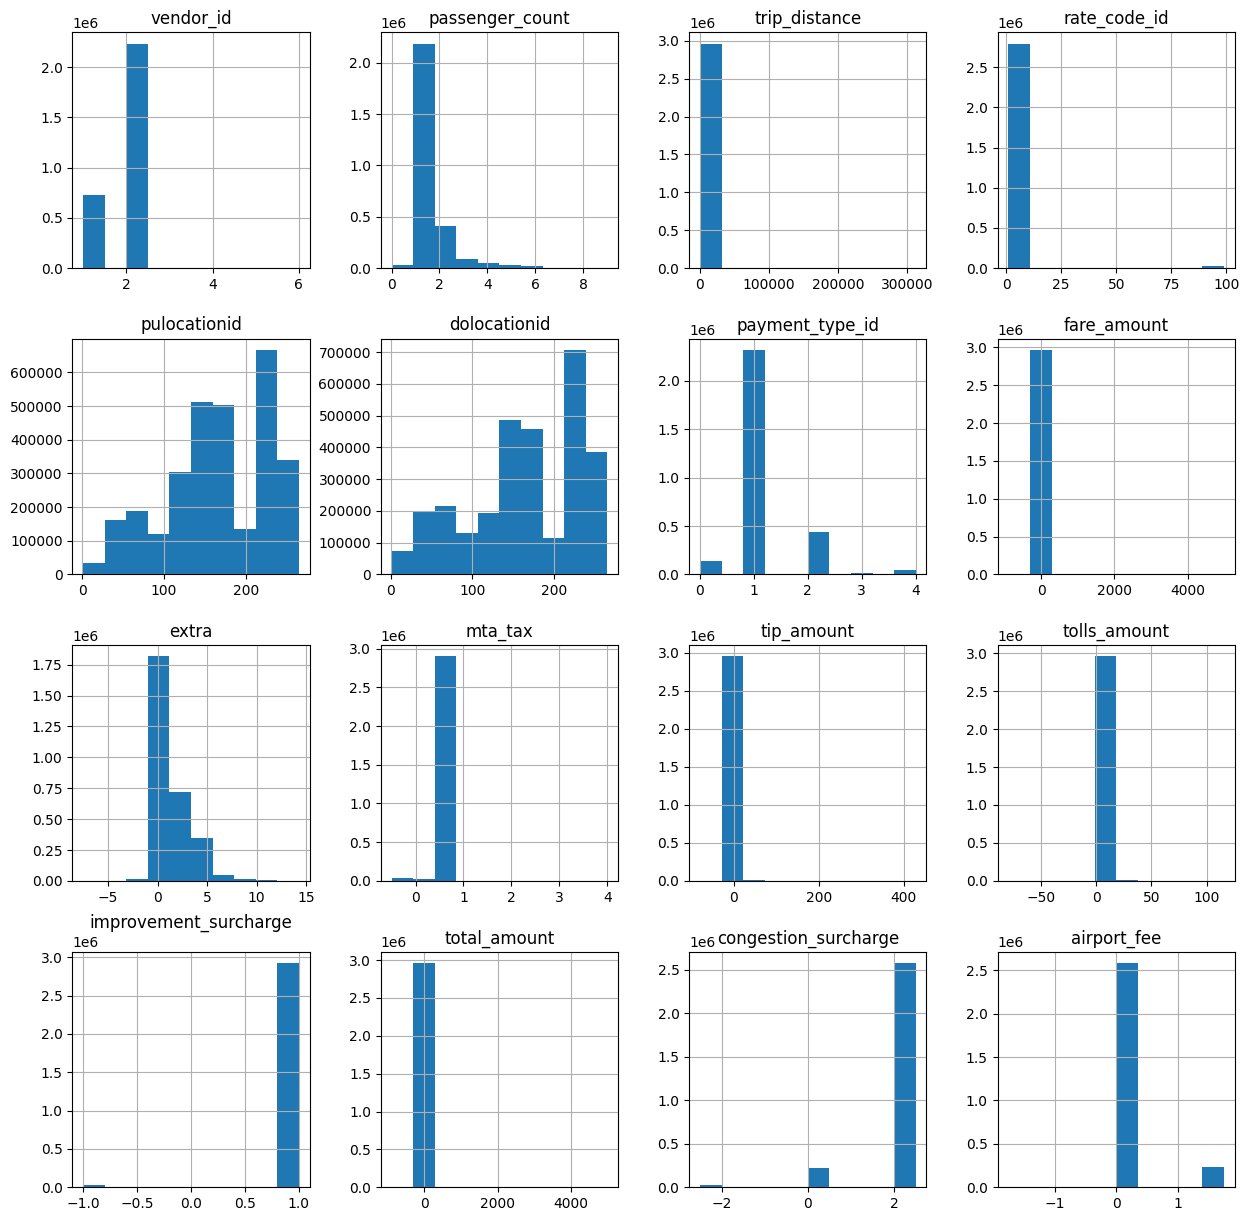

In [31]:
df[numeric_cols].hist(figsize=(15,15));


**Datetime features:**

In [32]:
vis_time_df = df[cat_cols].copy()

# Convert the pickup and dropoff datetime columns to datetime type
vis_time_df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
vis_time_df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Extract the day and time from the pickup and dropoff datetime columns
vis_time_df['tpep_pickup_day'] = vis_time_df['tpep_pickup_datetime'].dt.dayofweek
vis_time_df['tpep_pickup_time'] = vis_time_df['tpep_pickup_datetime'].dt.hour

vis_time_df['tpep_dropoff_day'] = vis_time_df['tpep_dropoff_datetime'].dt.dayofweek
vis_time_df['tpep_dropoff_time'] = vis_time_df['tpep_dropoff_datetime'].dt.hour

vis_time_df.head()

,trip_id,tpep_pickup_datetime,tpep_dropoff_datetime,tpep_pickup_day,tpep_pickup_time,tpep_dropoff_day,tpep_dropoff_time
0,1,2024-01-02 05:32:22,2024-01-02 05:39:16,1,5,1,5
1,2,2024-01-02 05:20:48,2024-01-02 05:32:18,1,5,1,5
2,3,2024-01-02 05:55:43,2024-01-02 06:29:21,1,5,1,6
3,4,2024-01-02 05:27:40,2024-01-02 05:31:42,1,5,1,5
4,5,2024-01-02 05:55:40,2024-01-02 06:05:58,1,5,1,6


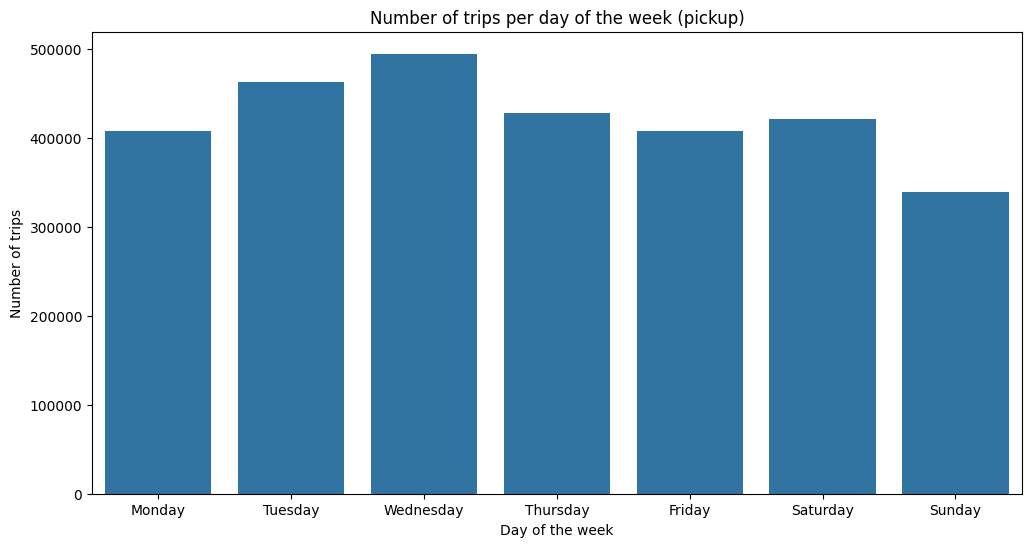

In [33]:
plt.figure(figsize=(12, 6))
sns.countplot(x='tpep_pickup_day', data=vis_time_df)
plt.title('Number of trips per day of the week (pickup)')
plt.xlabel('Day of the week')
plt.ylabel('Number of trips')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

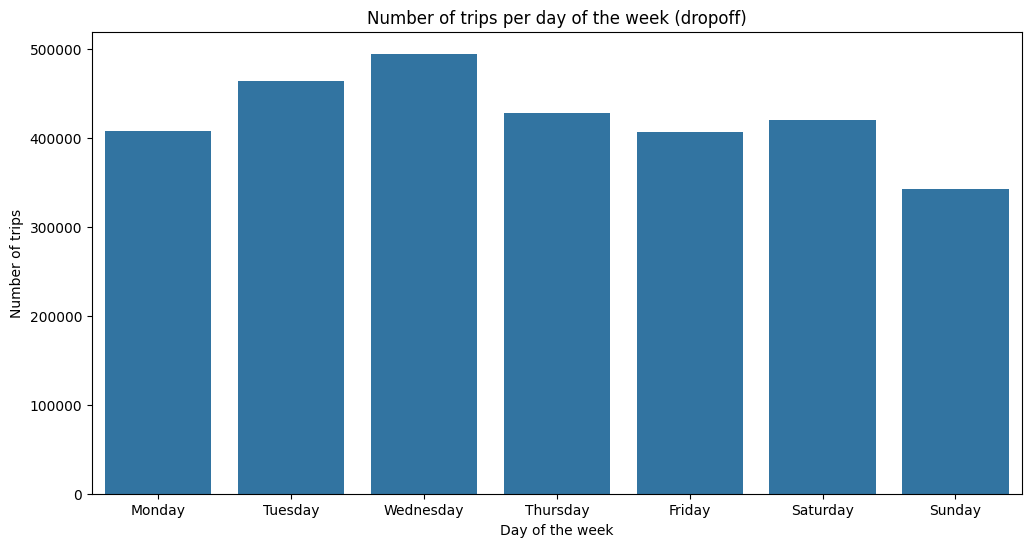

In [34]:
plt.figure(figsize=(12, 6))
sns.countplot(x='tpep_dropoff_day', data=vis_time_df)
plt.title('Number of trips per day of the week (dropoff)')
plt.xlabel('Day of the week')
plt.ylabel('Number of trips')
plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.show()

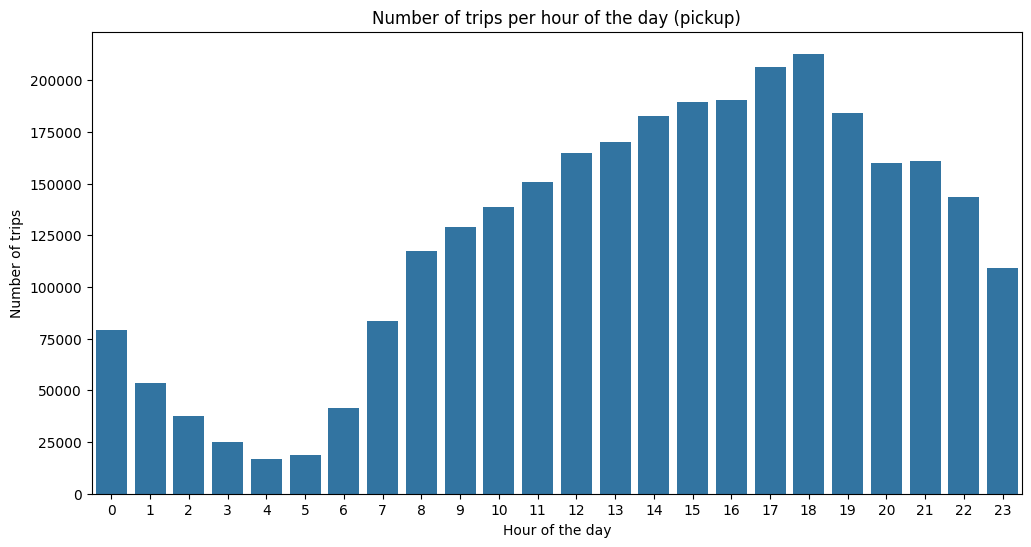

In [35]:
plt.figure(figsize=(12, 6))
sns.countplot(x='tpep_pickup_time', data=vis_time_df)
plt.title('Number of trips per hour of the day (pickup)')
plt.xlabel('Hour of the day')
plt.ylabel('Number of trips')
plt.show()

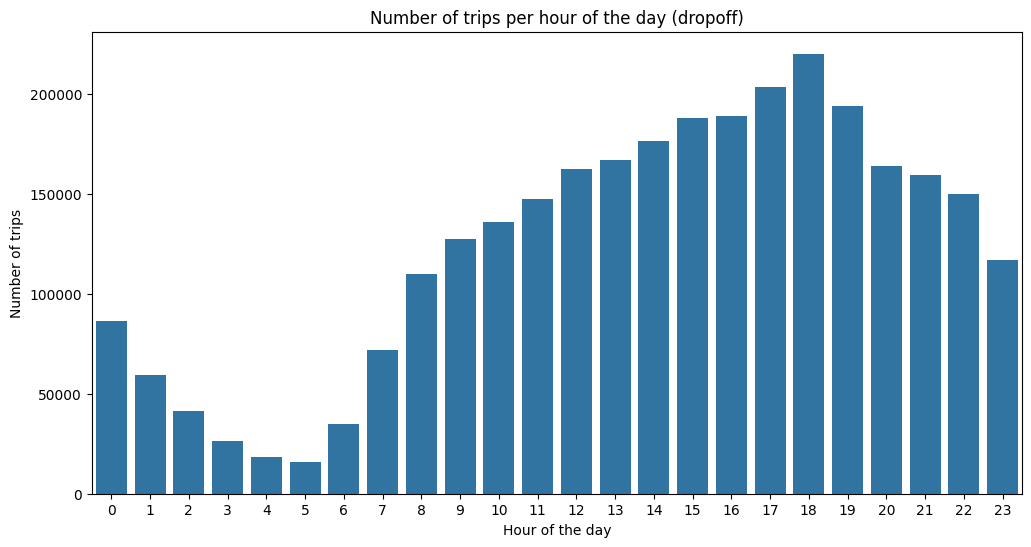

In [36]:
plt.figure(figsize=(12, 6))
sns.countplot(x='tpep_dropoff_time', data=vis_time_df)
plt.title('Number of trips per hour of the day (dropoff)')
plt.xlabel('Hour of the day')
plt.ylabel('Number of trips')
plt.show()

In [37]:
vis_time_df['trip_duration'] = (vis_time_df['tpep_dropoff_datetime'] - vis_time_df['tpep_pickup_datetime']).dt.total_seconds() / 60  # Duration in minutes

vis_time_df.head()

,trip_id,tpep_pickup_datetime,tpep_dropoff_datetime,tpep_pickup_day,tpep_pickup_time,tpep_dropoff_day,tpep_dropoff_time,trip_duration
0,1,2024-01-02 05:32:22,2024-01-02 05:39:16,1,5,1,5,6.900000
1,2,2024-01-02 05:20:48,2024-01-02 05:32:18,1,5,1,5,11.500000
2,3,2024-01-02 05:55:43,2024-01-02 06:29:21,1,5,1,6,33.633333
3,4,2024-01-02 05:27:40,2024-01-02 05:31:42,1,5,1,5,4.033333
4,5,2024-01-02 05:55:40,2024-01-02 06:05:58,1,5,1,6,10.300000


In [38]:
vis_time_df.describe()

,trip_id,tpep_pickup_datetime,tpep_dropoff_datetime,tpep_pickup_day,tpep_pickup_time,tpep_dropoff_day,tpep_dropoff_time,trip_duration
count,2.964624e+06,2964624,2964624,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06
mean,1.482312e+06,2024-01-17 00:46:36.431092992,2024-01-17 01:02:13.208131584,2.872378e+00,1.418230e+01,2.875336e+00,1.424654e+01,1.561295e+01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.356667e+01
25%,7.411568e+05,2024-01-09 15:59:19.750000128,2024-01-09 16:16:23,1.000000e+00,1.100000e+01,1.000000e+00,1.100000e+01,7.150000e+00
50%,1.482312e+06,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,3.000000e+00,1.500000e+01,3.000000e+00,1.500000e+01,1.163333e+01
75%,2.223468e+06,2024-01-24 18:23:52.249999872,2024-01-24 18:40:29,5.000000e+00,1.900000e+01,5.000000e+00,1.900000e+01,1.868333e+01
max,2.964624e+06,2024-02-01 00:01:15,2024-02-02 13:56:52,6.000000e+00,2.300000e+01,6.000000e+00,2.300000e+01,9.455400e+03
std,8.558134e+05,NaN,NaN,1.936978e+00,5.724264e+00,1.939295e+00,5.811237e+00,3.485105e+01


**Remarques :**
- `trip_duration` présente une valeur négative, ce qui n'est pas possible dans un contexte réel.

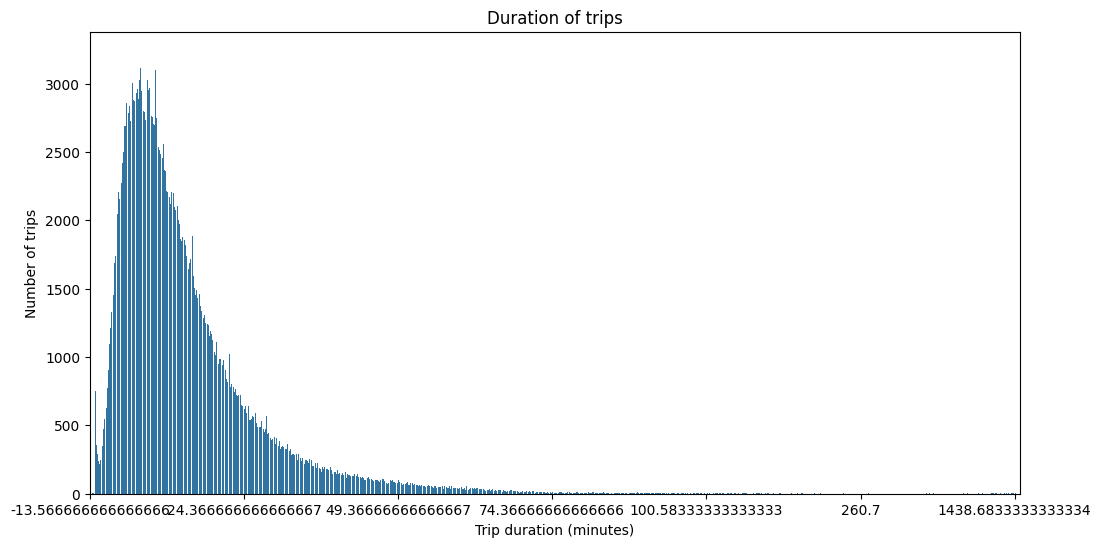

In [39]:
plt.figure(figsize=(12, 6))
sns.countplot(x='trip_duration', data=vis_time_df)
plt.title('Duration of trips')
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Number of trips')

plt.xticks(range(0, int(vis_time_df['trip_duration'].max()) + 1, 1500))

plt.show()

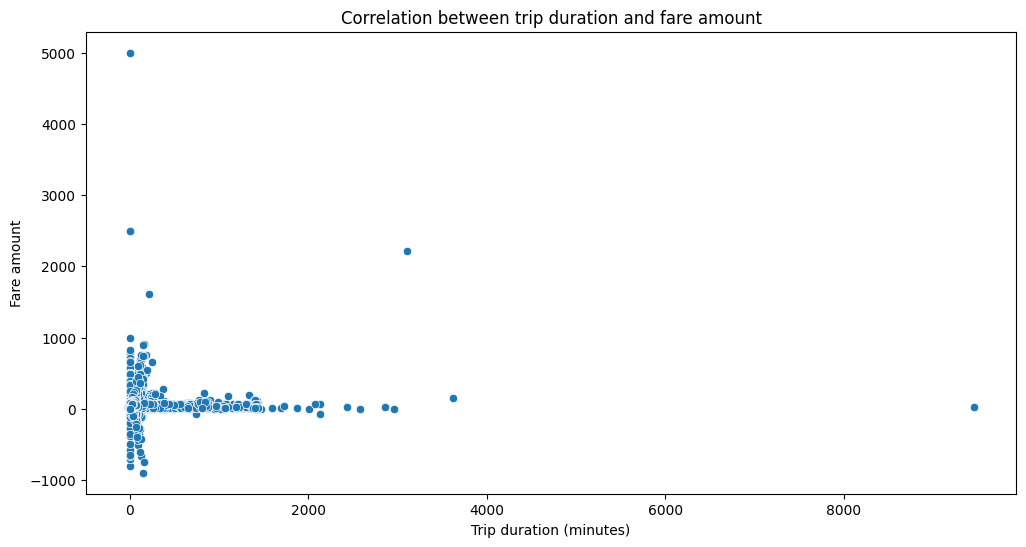

In [41]:
merged_df = pd.merge(vis_time_df, df, on='trip_id', how='inner')

plt.figure(figsize=(12, 6))
sns.scatterplot(x='trip_duration', y='fare_amount', data=merged_df)
plt.title('Correlation between trip duration and fare amount')
plt.xlabel('Trip duration (minutes)')
plt.ylabel('Fare amount')
plt.show()

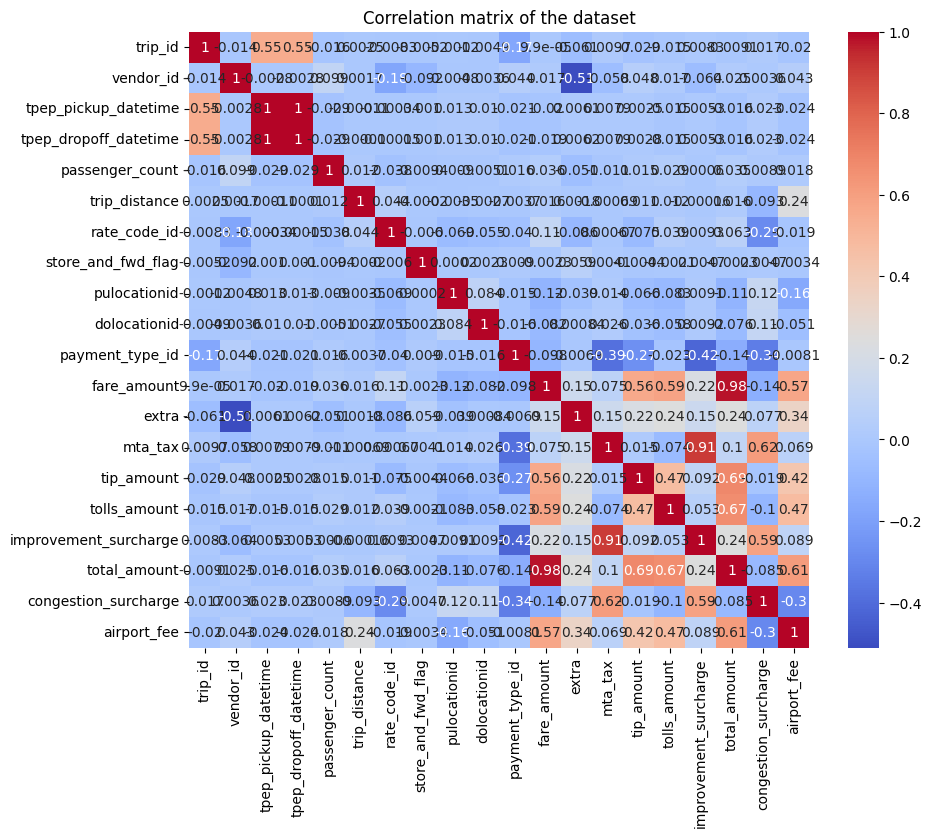

In [42]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation matrix of the dataset')
plt.show()

**Remarques :**
La corrélation entre la durée du voyage et son prix montre quelques valeurs aberrantes

### Dashboard KPIs

- Total number of trips
- Average trip duration
- Average travel distance
- Total ride amount
- Percentage of rides with surcharges
- Payment Type Breakdown
- Correlation between trip duration and fare amount
- Time Trends (trips by time of day, revenue by day of the week, etc.)
- Geographic distribution of trips
- Vehicle occupancy rate